In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import random

from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
# Load the CSV file into a DataFrame
events_df = pd.read_csv('data/events.csv')

# Display the first few rows of the dataset
events_df.head()

,id,name,tags,date
0,5e4ea2fbbc4124000ec93d8b,Members' Social with Stephen Reid,NaN,2020-03-27
1,5edfba3873ca70000e3e5f91,Weekly Psychedelic Hangout,NaN,2020-06-10
2,5e4d75dffb11270006be7479,Headless Way: A Day with Richard Lang (Members...,NaN,2020-03-21
3,5e9d95b6e05bb5000405bf6b,Headless Way: Online Workshop with Richard Lang,NaN,2020-05-11
4,5e9d95b7e05bb5000405bf6c,Come Whine With Me,NaN,2020-04-30


In [ ]:
# Drop rows with missing tags
events_df = events_df.dropna(subset=['tags'])
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 163 to 3043
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2055 non-null   object
 1   name    2055 non-null   object
 2   tags    2055 non-null   object
 3   date    2055 non-null   object
dtypes: object(4)
memory usage: 80.3+ KB


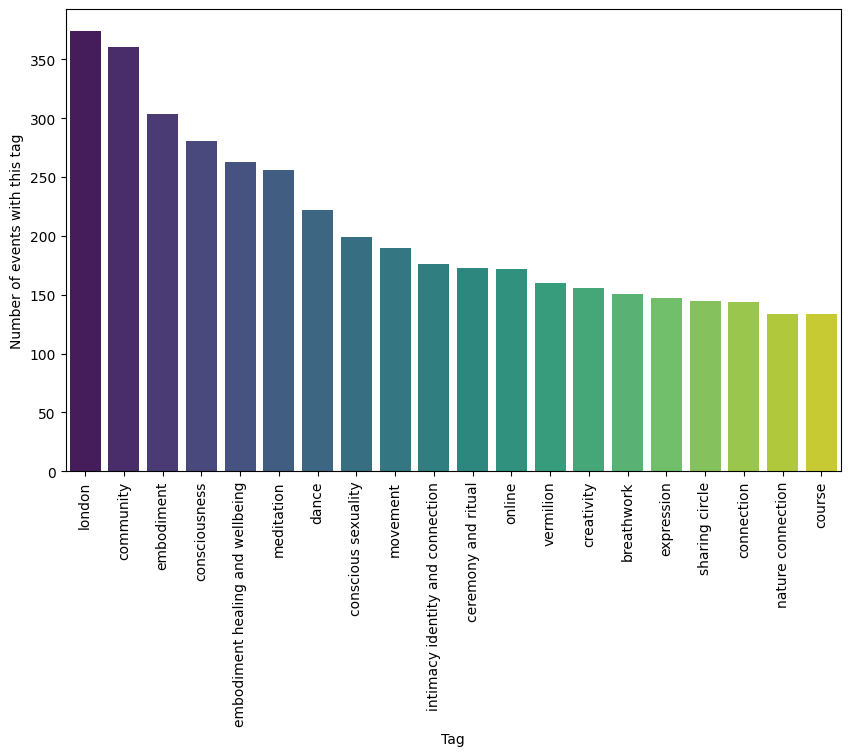

In [ ]:
# Count the number of events for each tag
tag_counts = events_df['tags'].str.split(', ').explode().value_counts()

# Limit to top 20 tags
top_20_tags = tag_counts[:20]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_tags.index, y=top_20_tags.values, palette='viridis')
plt.xlabel('Tag')
plt.ylabel('Number of events with this tag')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Extract the 'name' column from the DataFrame to use as features
X = events_df['name'].values

# Convert the 'tags' column into a multi-label format suitable for machine learning
# The MultiLabelBinarizer converts each list of tags into a binary array
# where each column corresponds to one possible tag value
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(events_df['tags'].str.split(', '))

In [ ]:
# Split the dataset into training and test sets for raw text data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(SGDClassifier()))
])

# Define the parameter grid
param_grid = {
    'clf__estimator__loss': ['log_loss', 'hinge', 'squared_hinge']
}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_micro')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the results
results = grid_search.cv_results_

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'clf__estimator__loss': 'hinge'}
Best score:  0.6382138986940978


In [ ]:
# Predict the tags for the test set
y_pred = grid_search.predict(X_test)

# Pick 5 random items from the test set
random_indices = random.sample(range(len(X_test)), 5)

# Output actual and predicted tags for these items
for i in random_indices:
    print("Event: ", X_test[i])
    print("Actual tags: ", ', '.join(mlb.inverse_transform(y_test[i:i+1])[0]))
    print("Predicted tags: ", ', '.join(mlb.inverse_transform(y_pred[i:i+1])[0]))
    print("\n")

Event:  Unlocking Vitality: Online Breathwork Journey
Actual tags:  breath, breathwork, breathworkonline, conscious connected breathwork, onlinebreathwork, psychedelic breathwork, pyschedelic breath, somatic breathwork
Predicted tags:  breathwork, conscious connected breathwork


Event:  Gemini  New Moon Circle
Actual tags:  ceremony and ritual, divine feminine, manifesting, moon circle, new moon ceremony, setting intentions, sharing circle
Predicted tags:  divine feminine, manifesting, moon circle, new moon, setting intentions, sharing circle


Event:  Altered States FREE Online Social for discussing psychedelic & mystical experiences
Actual tags:  altered states, ayahuasca, conscious, dmt, free, friends, kundalini, lsd, meditation, mystical experiences, online, psychedelic, psychonaut, social, yoga
Predicted tags:  psychedelic therapy


Event:  EDB Sundays | Sun 16 Oct | Cacao Ceremony, Ecstatic Dance & Sound Journey w/ OSARA, Pixi Pete & Deya CacaoAmor
Actual tags:  bristol, conscio